In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import folium
import re
from bokeh.io import output_notebook
from bokeh.sampledata import us_states
from bokeh.plotting import figure, show, output_file, ColumnDataSource
from bokeh.models import HoverTool, Range1d
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
!pip install plotly 
!pip install dash
!pip install chart_studio 
import chart_studio
import plotly.express as px
import plotly.io as pio
import chart_studio.tools as tls

In [4]:
# Loading the file of prescription drug abuse

url_file = 'https://raw.githubusercontent.com/IBM/predict-opioid-prescribers/master/data/prescriber-info.csv'

In [5]:
# Loading and reading the opioids file
url_file2 = 'https://raw.githubusercontent.com/IBM/predict-opioid-prescribers/master/data/opioids.csv'
opioids = pd.read_csv(url_file2)

In [6]:
# Reading the file from that website via pd.read_csv()
df = pd.read_csv(url_file, na_values='?')
print(df.shape)
df.head()

(25000, 256)


,NPI,Gender,State,Credentials,Specialty,ABILIFY,ACETAMINOPHEN.CODEINE,ACYCLOVIR,ADVAIR.DISKUS,AGGRENOX,ALENDRONATE.SODIUM,ALLOPURINOL,ALPRAZOLAM,AMIODARONE.HCL,AMITRIPTYLINE.HCL,AMLODIPINE.BESYLATE,AMLODIPINE.BESYLATE.BENAZEPRIL,AMOXICILLIN,AMOX.TR.POTASSIUM.CLAVULANATE,AMPHETAMINE.SALT.COMBO,ATENOLOL,ATORVASTATIN.CALCIUM,AVODART,AZITHROMYCIN,BACLOFEN,BD.ULTRA.FINE.PEN.NEEDLE,BENAZEPRIL.HCL,BENICAR,BENICAR.HCT,BENZTROPINE.MESYLATE,BISOPROLOL.HYDROCHLOROTHIAZIDE,BRIMONIDINE.TARTRATE,BUMETANIDE,BUPROPION.HCL.SR,BUPROPION.XL,BUSPIRONE.HCL,BYSTOLIC,CARBAMAZEPINE,CARBIDOPA.LEVODOPA,CARISOPRODOL,...,SERTRALINE.HCL,SIMVASTATIN,SOTALOL,SPIRIVA,SPIRONOLACTONE,SUCRALFATE,SULFAMETHOXAZOLE.TRIMETHOPRIM,SUMATRIPTAN.SUCCINATE,SYMBICORT,SYNTHROID,TAMSULOSIN.HCL,TEMAZEPAM,TERAZOSIN.HCL,TIMOLOL.MALEATE,TIZANIDINE.HCL,TOLTERODINE.TARTRATE.ER,TOPIRAMATE,TOPROL.XL,TORSEMIDE,TRAMADOL.HCL,TRAVATAN.Z,TRAZODONE.HCL,TRIAMCINOLONE.ACETONIDE,TRIAMTERENE.HYDROCHLOROTHIAZID,VALACYCLOVIR,VALSARTAN,VALSARTAN.HYDROCHLOROTHIAZIDE,VENLAFAXINE.HCL,VENLAFAXINE.HCL.ER,VENTOLIN.HFA,VERAPAMIL.ER,VESICARE,VOLTAREN,VYTORIN,WARFARIN.SODIUM,XARELTO,ZETIA,ZIPRASIDONE.HCL,ZOLPIDEM.TARTRATE,Opioid.Prescriber
0,1710982582,M,TX,DDS,Dentist,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,1245278100,F,AL,MD,General Surgery,0,0,0,0,0,0,0,134,0,0,15,0,0,0,0,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15,0,0,0,45,...,29,51,0,0,0,0,0,0,0,0,0,0,0,0,16,0,0,0,0,36,0,31,0,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,35,1
2,1427182161,F,NY,M.D.,General Practice,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19,42,0,0,0,0,0,...,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,0,0,0,0,0,0,47,0,0,0,0,0,0,0,0,0,25,0
3,1669567541,M,AZ,MD,Internal Medicine,0,43,0,0,0,21,0,0,0,0,58,0,0,0,0,0,13,0,0,27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,15,80,0,0,0,0,0,0,0,52,18,0,0,0,0,0,0,0,0,90,0,0,16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,1679650949,M,NV,M.D.,Hematology/Oncology,0,0,0,0,0,0,0,0,0,19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,14,0,0,0,0,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17,28,0,0,0,1


In [7]:
df.describe()

,NPI,ABILIFY,ACETAMINOPHEN.CODEINE,ACYCLOVIR,ADVAIR.DISKUS,AGGRENOX,ALENDRONATE.SODIUM,ALLOPURINOL,ALPRAZOLAM,AMIODARONE.HCL,AMITRIPTYLINE.HCL,AMLODIPINE.BESYLATE,AMLODIPINE.BESYLATE.BENAZEPRIL,AMOXICILLIN,AMOX.TR.POTASSIUM.CLAVULANATE,AMPHETAMINE.SALT.COMBO,ATENOLOL,ATORVASTATIN.CALCIUM,AVODART,AZITHROMYCIN,BACLOFEN,BD.ULTRA.FINE.PEN.NEEDLE,BENAZEPRIL.HCL,BENICAR,BENICAR.HCT,BENZTROPINE.MESYLATE,BISOPROLOL.HYDROCHLOROTHIAZIDE,BRIMONIDINE.TARTRATE,BUMETANIDE,BUPROPION.HCL.SR,BUPROPION.XL,BUSPIRONE.HCL,BYSTOLIC,CARBAMAZEPINE,CARBIDOPA.LEVODOPA,CARISOPRODOL,CARTIA.XT,CARVEDILOL,CEFUROXIME,CELEBREX,...,SERTRALINE.HCL,SIMVASTATIN,SOTALOL,SPIRIVA,SPIRONOLACTONE,SUCRALFATE,SULFAMETHOXAZOLE.TRIMETHOPRIM,SUMATRIPTAN.SUCCINATE,SYMBICORT,SYNTHROID,TAMSULOSIN.HCL,TEMAZEPAM,TERAZOSIN.HCL,TIMOLOL.MALEATE,TIZANIDINE.HCL,TOLTERODINE.TARTRATE.ER,TOPIRAMATE,TOPROL.XL,TORSEMIDE,TRAMADOL.HCL,TRAVATAN.Z,TRAZODONE.HCL,TRIAMCINOLONE.ACETONIDE,TRIAMTERENE.HYDROCHLOROTHIAZID,VALACYCLOVIR,VALSARTAN,VALSARTAN.HYDROCHLOROTHIAZIDE,VENLAFAXINE.HCL,VENLAFAXINE.HCL.ER,VENTOLIN.HFA,VERAPAMIL.ER,VESICARE,VOLTAREN,VYTORIN,WARFARIN.SODIUM,XARELTO,ZETIA,ZIPRASIDONE.HCL,ZOLPIDEM.TARTRATE,Opioid.Prescriber
count,2.500000e+04,25000.000000,25000.000000,25000.00000,25000.000000,25000.000000,25000.000000,25000.000000,25000.00000,25000.000000,25000.00000,25000.000000,25000.000000,25000.000000,25000.00000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,...,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.00000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.00000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000
mean,1.498162e+09,3.157160,2.370400,1.05368,7.041000,0.708440,8.962840,9.305720,16.12812,2.394840,4.34716,44.314600,2.843240,6.005960,2.78372,0.985760,15.788000,39.556400,1.515040,7.571920,3.302600,3.096040,3.772560,1.615040,0.958840,2.706720,0.884800,1.278560,1.121840,2.195160,2.999320,2.869120,2.350000,1.261760,2.949840,1.451280,0.637240,16.600280,0.845560,3.425040,...,13.667200,41.300440,1.167080,6.664280,5.665120,1.190520,4.263960,0.884360,3.374720,6.467400,14.692160,3.79820,2.196880,2.475200,3.334880,0.602120,2.704800,0.709080,1.231640,16.267720,2.116600,11.742480,3.666200,5.459200,0.939880,0.818160,3.887360,0.819800,4.507720,2.232840,2.18804,2.238160,2.551600,0.806240,19.198040,3.348240,4.070880,1.119440,11.573120,0.587520
std,2.877233e+08,20.755819,11.631601,6.66110,25.898648,5.224049,36.520987,29.375476,69.35317,14.266314,14.81288,115.478958,14.286574,17.095137,10.41416,12.251558,47.329884,108.253796,13.368265,21.853902,16.850191,15.221298,18.236992,9.333193,7.048337,24.362232,7.365086,13.672265,8.282829,10.900719,15.762898,14.445285,14.507485,8.380223,24.597577,12.876746,4.137769,57.080712,6.649129,14.495453,...,43.181956,109.405196,10.561834,28.100944,21.423837,8.732976,15.496956,5.084803,20.446102,37.661763,61.782253,21.45801,11.002742,23.755893,22.819189,4.364733,15.078386,4.885174,9.596286,47.092846,19.727139,42.925881,16.305333,20.825755,5.549557,4.587236,17.241615,5.217434,17.578737,10.423608,10.08554,13.325884,23.327117,4.951929,86.501125,17.127556,18.467437,10.299475,39.136616,0.492291
min,1.003002e+09,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.

In [8]:
df.info

<bound method DataFrame.info of               NPI Gender  ... ZOLPIDEM.TARTRATE Opioid.Prescriber
0      1710982582      M  ...                 0                 1
1      1245278100      F  ...                35                 1
2      1427182161      F  ...                25                 0
3      1669567541      M  ...                 0                 1
4      1679650949      M  ...                 0                 1
...           ...    ...  ...               ...               ...
24995  1619019353      F  ...                 0                 1
24996  1780693671      F  ...                 0                 1
24997  1346270956      M  ...                 0                 1
24998  1023116514      F  ...                 0                 1
24999  1518913672      M  ...                 0                 0

[25000 rows x 256 columns]>

In [ ]:
# Checking for any missing values
df.isnull().sum()

NPI                    0
Gender                 0
State                  0
Credentials          763
Specialty              0
                    ... 
XARELTO                0
ZETIA                  0
ZIPRASIDONE.HCL        0
ZOLPIDEM.TARTRATE      0
Opioid.Prescriber      0
Length: 256, dtype: int64

In [ ]:
df.dtypes

NPI                   int64
Gender               object
State                object
Credentials          object
Specialty            object
                      ...  
XARELTO               int64
ZETIA                 int64
ZIPRASIDONE.HCL       int64
ZOLPIDEM.TARTRATE     int64
Opioid.Prescriber     int64
Length: 256, dtype: object

In [10]:
# List of 11 common opioid prescriptions
ops = list(re.sub(r'[-\s]','.',x) for x in opioids.values[:,0])
prescribed_ops = list(set(ops) & set(df.columns))

for i,drug in enumerate(prescribed_ops):
    print (i+1,drug)

1 METHADONE.HCL
2 TRAMADOL.HCL
3 OXYCONTIN
4 MORPHINE.SULFATE.ER
5 ACETAMINOPHEN.CODEINE
6 OXYCODONE.ACETAMINOPHEN
7 MORPHINE.SULFATE
8 OXYCODONE.HCL
9 HYDROMORPHONE.HCL
10 HYDROCODONE.ACETAMINOPHEN
11 FENTANYL


In [11]:
# Adding new columns which are NumOpioids, NumPrescriptions,and FracOp to our dataset
df['NumOpioids'] = df.apply(lambda x: sum(x[prescribed_ops]),axis=1)
df['NumPrescriptions'] = df.apply(lambda x: sum(x.iloc[5:255]),axis=1)
df['FracOp'] = df.apply(lambda x: float(x['NumOpioids'])/x['NumPrescriptions'],axis=1)
print(df.shape)
df.head()

(25000, 259)


,NPI,Gender,State,Credentials,Specialty,ABILIFY,ACETAMINOPHEN.CODEINE,ACYCLOVIR,ADVAIR.DISKUS,AGGRENOX,ALENDRONATE.SODIUM,ALLOPURINOL,ALPRAZOLAM,AMIODARONE.HCL,AMITRIPTYLINE.HCL,AMLODIPINE.BESYLATE,AMLODIPINE.BESYLATE.BENAZEPRIL,AMOXICILLIN,AMOX.TR.POTASSIUM.CLAVULANATE,AMPHETAMINE.SALT.COMBO,ATENOLOL,ATORVASTATIN.CALCIUM,AVODART,AZITHROMYCIN,BACLOFEN,BD.ULTRA.FINE.PEN.NEEDLE,BENAZEPRIL.HCL,BENICAR,BENICAR.HCT,BENZTROPINE.MESYLATE,BISOPROLOL.HYDROCHLOROTHIAZIDE,BRIMONIDINE.TARTRATE,BUMETANIDE,BUPROPION.HCL.SR,BUPROPION.XL,BUSPIRONE.HCL,BYSTOLIC,CARBAMAZEPINE,CARBIDOPA.LEVODOPA,CARISOPRODOL,...,SPIRIVA,SPIRONOLACTONE,SUCRALFATE,SULFAMETHOXAZOLE.TRIMETHOPRIM,SUMATRIPTAN.SUCCINATE,SYMBICORT,SYNTHROID,TAMSULOSIN.HCL,TEMAZEPAM,TERAZOSIN.HCL,TIMOLOL.MALEATE,TIZANIDINE.HCL,TOLTERODINE.TARTRATE.ER,TOPIRAMATE,TOPROL.XL,TORSEMIDE,TRAMADOL.HCL,TRAVATAN.Z,TRAZODONE.HCL,TRIAMCINOLONE.ACETONIDE,TRIAMTERENE.HYDROCHLOROTHIAZID,VALACYCLOVIR,VALSARTAN,VALSARTAN.HYDROCHLOROTHIAZIDE,VENLAFAXINE.HCL,VENLAFAXINE.HCL.ER,VENTOLIN.HFA,VERAPAMIL.ER,VESICARE,VOLTAREN,VYTORIN,WARFARIN.SODIUM,XARELTO,ZETIA,ZIPRASIDONE.HCL,ZOLPIDEM.TARTRATE,Opioid.Prescriber,NumOpioids,NumPrescriptions,FracOp
0,1710982582,M,TX,DDS,Dentist,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,17,29,0.586207
1,1245278100,F,AL,MD,General Surgery,0,0,0,0,0,0,0,134,0,0,15,0,0,0,0,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15,0,0,0,45,...,0,0,0,0,0,0,0,0,0,0,0,16,0,0,0,0,36,0,31,0,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,35,1,362,1418,0.255289
2,1427182161,F,NY,M.D.,General Practice,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19,42,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,0,0,0,0,0,0,47,0,0,0,0,0,0,0,0,0,25,0,0,289,0.000000
3,1669567541,M,AZ,MD,Internal Medicine,0,43,0,0,0,21,0,0,0,0,58,0,0,0,0,0,13,0,0,27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,52,18,0,0,0,0,0,0,0,0,90,0,0,16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,559,1757,0.318156
4,1679650949,M,NV,M.D.,Hematology/Oncology,0,0,0,0,0,0,0,0,0,19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,14,0,0,0,0,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17,28,0,0,0,1,66,179,0.368715


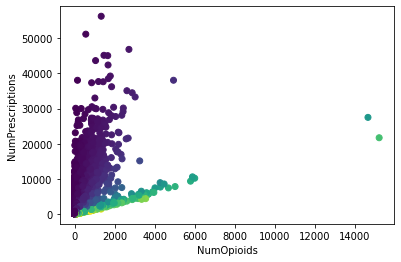

In [ ]:
# A scatter plot the FracOp of NumOpioids and NumPrescriptions
plt.scatter(df['NumOpioids'], df['NumPrescriptions'], c=df['FracOp']);
plt.xlabel('NumOpioids')
plt.ylabel('NumPrescriptions')
plt.show()

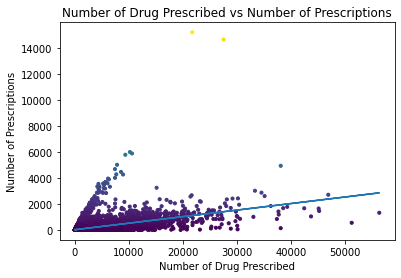

In [ ]:
# Making a scatter plot (linear) for NumPrescriptions and NumOpioids
a = df['NumOpioids'].shape[0]
x = df['NumPrescriptions']
y = df['NumOpioids']

area = np.pi*3

plt.scatter(x, y, s=area, c=df['NumOpioids']);

m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b, '-')

plt.title('Number of Drug Prescribed vs Number of Prescriptions')
plt.xlabel('Number of Drug Prescribed')
plt.ylabel('Number of Prescriptions')
plt.show();

In [ ]:
# Unique values for overall genders
df['Gender'].unique()

array(['M', 'F'], dtype=object)

In [ ]:
# Male_teens who take some drug
male_teens = df['Opioid.Prescriber'][df['Gender'] == 'M']
male_teens.value_counts()

1    9553
0    6021
Name: Opioid.Prescriber, dtype: int64

In [ ]:
# Female_teens who take some drug
female_teens = df['Opioid.Prescriber'][df['Gender'] == 'F']
female_teens.value_counts()

1    5135
0    4291
Name: Opioid.Prescriber, dtype: int64

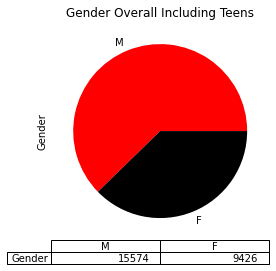

In [ ]:
# Making a pie chart with table that generates the gender overall including teens
df[df['Gender'].isin(['M','F'])]["Gender"].value_counts().plot(kind='pie',title= "Gender Overall Including Teens",colors= ['red','black'], table =True);

In [ ]:
# Opioid Prescriber count Gender and NPI for teens overall
teen_count = pd.DataFrame(df[['Gender','NPI']].groupby('Gender').count())

teen_count.reset_index(level=0, inplace=True)

teen_count.columns = ['Gender', 'Total_teens_prescribers']

teen_count_prescribedOpioids = pd.DataFrame(df.loc[df['Opioid.Prescriber']>0,['Gender','NPI']].groupby('Gender').count())
teen_count_prescribedOpioids.reset_index(level=0, inplace=True)

teen_count_prescribedOpioids.columns = ['Gender', 'Opioid_teens_prescribers']
teen_count = pd.merge(teen_count, teen_count_prescribedOpioids,  how='left', on="Gender")

teen_count = teen_count.fillna(0)

teen_count = teen_count.sort_values('Total_teens_prescribers')

teen_count.head()

,Gender,Total_teens_prescribers,Opioid_teens_prescribers
0,F,9426,5135
1,M,15574,9553


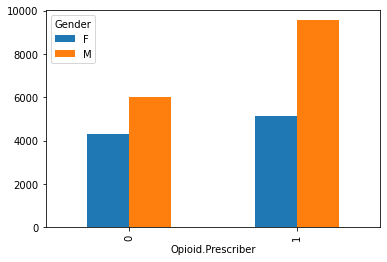

In [ ]:
# Crosstab for Opioid.Prescriber by Gender
pd.crosstab(df['Opioid.Prescriber'], df['Gender']).sort_index().plot(kind='bar');

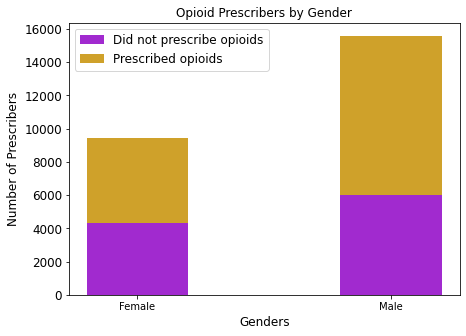

In [ ]:
# Prescription drug abuse by overall gender
gender_count = np.array(list(df[['Gender','NPI']].groupby('Gender').count()['NPI']))

gender_count = np.append([gender_count],[list(df.loc[df['Opioid.Prescriber']>0,['Gender','NPI']].groupby('Gender').count()['NPI'])], axis=0)

gender_count[0] = gender_count[0]-gender_count[1]

fig = plt.gcf()
fig.set_size_inches( 7, 5)

configs = gender_count[0]
N = configs.shape[0]
ind = np.arange(N)
width = 0.4
p1 = plt.bar(ind, gender_count[0], width, color='#A12ACF')
p2 = plt.bar(ind, gender_count[1], width, bottom=gender_count[0], color='#CFA12A')

plt.yticks(fontsize=12)
plt.ylabel("Number of Prescribers", fontsize=12)
plt.xticks(ind,["Female","Male"])
plt.xlabel('Genders', fontsize=12)
plt.title("Opioid Prescribers by Gender")
plt.legend([p1[0], p2[0]], ["Did not prescribe opioids","Prescribed opioids"], fontsize=12, fancybox=True)
plt.show()

In [ ]:
# The percentage of Opioid Prescribers overall
print (float(df['Opioid.Prescriber'].sum())*100/df.shape[0],"%")

58.752 %


In [15]:
# The mean of num_opioids per speciality
speci_numops = df.groupby('Specialty')['NumOpioids'].mean().sort_values(ascending=False)

speci_numops

Specialty
Interventional Pain Management          1173.191489
Addiction Medicine                      1167.000000
Pain Management                         1135.000000
Anesthesiology                           507.507246
Physical Medicine and Rehabilitation     440.150000
                                           ...     
Licensed Clinical Social Worker            0.000000
Counselor                                  0.000000
Hospital (Dmercs Only)                     0.000000
Slide Preparation Facility                 0.000000
Homeopath                                  0.000000
Name: NumOpioids, Length: 109, dtype: float64

In [16]:
# The mean of frac_opioids per speciality
speci_fracops = df.groupby('Specialty')['FracOp'].mean().sort_values(ascending=False)

speci_fracops 

Specialty
Hand Surgery                       0.811180
Orthopaedic Surgery                0.691484
Surgery                            0.638596
Orthopedic Surgery                 0.623872
General Surgery                    0.622490
                                     ...   
Licensed Clinical Social Worker    0.000000
Physical Therapist                 0.000000
Hospital (Dmercs Only)             0.000000
Slide Preparation Facility         0.000000
Specialist/Technologist            0.000000
Name: FracOp, Length: 109, dtype: float64

In [17]:
# Adding two new columns to our dataset which are O.diff and FracO.Diff
df['O.Diff'] = df.apply(lambda x: x['NumOpioids'] -speci_numops [x['Specialty']],axis=1)
df['FracO.Diff'] = df.apply(lambda x: x['FracOp'] - speci_fracops [x['Specialty']],axis=1)
print(df.shape)
df.head()

(25000, 261)


,NPI,Gender,State,Credentials,Specialty,ABILIFY,ACETAMINOPHEN.CODEINE,ACYCLOVIR,ADVAIR.DISKUS,AGGRENOX,ALENDRONATE.SODIUM,ALLOPURINOL,ALPRAZOLAM,AMIODARONE.HCL,AMITRIPTYLINE.HCL,AMLODIPINE.BESYLATE,AMLODIPINE.BESYLATE.BENAZEPRIL,AMOXICILLIN,AMOX.TR.POTASSIUM.CLAVULANATE,AMPHETAMINE.SALT.COMBO,ATENOLOL,ATORVASTATIN.CALCIUM,AVODART,AZITHROMYCIN,BACLOFEN,BD.ULTRA.FINE.PEN.NEEDLE,BENAZEPRIL.HCL,BENICAR,BENICAR.HCT,BENZTROPINE.MESYLATE,BISOPROLOL.HYDROCHLOROTHIAZIDE,BRIMONIDINE.TARTRATE,BUMETANIDE,BUPROPION.HCL.SR,BUPROPION.XL,BUSPIRONE.HCL,BYSTOLIC,CARBAMAZEPINE,CARBIDOPA.LEVODOPA,CARISOPRODOL,...,SUCRALFATE,SULFAMETHOXAZOLE.TRIMETHOPRIM,SUMATRIPTAN.SUCCINATE,SYMBICORT,SYNTHROID,TAMSULOSIN.HCL,TEMAZEPAM,TERAZOSIN.HCL,TIMOLOL.MALEATE,TIZANIDINE.HCL,TOLTERODINE.TARTRATE.ER,TOPIRAMATE,TOPROL.XL,TORSEMIDE,TRAMADOL.HCL,TRAVATAN.Z,TRAZODONE.HCL,TRIAMCINOLONE.ACETONIDE,TRIAMTERENE.HYDROCHLOROTHIAZID,VALACYCLOVIR,VALSARTAN,VALSARTAN.HYDROCHLOROTHIAZIDE,VENLAFAXINE.HCL,VENLAFAXINE.HCL.ER,VENTOLIN.HFA,VERAPAMIL.ER,VESICARE,VOLTAREN,VYTORIN,WARFARIN.SODIUM,XARELTO,ZETIA,ZIPRASIDONE.HCL,ZOLPIDEM.TARTRATE,Opioid.Prescriber,NumOpioids,NumPrescriptions,FracOp,O.Diff,FracO.Diff
0,1710982582,M,TX,DDS,Dentist,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,17,29,0.586207,7.946071,0.468841
1,1245278100,F,AL,MD,General Surgery,0,0,0,0,0,0,0,134,0,0,15,0,0,0,0,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15,0,0,0,45,...,0,0,0,0,0,0,0,0,0,16,0,0,0,0,36,0,31,0,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,35,1,362,1418,0.255289,314.322382,-0.367201
2,1427182161,F,NY,M.D.,General Practice,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19,42,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,0,0,0,0,0,0,47,0,0,0,0,0,0,0,0,0,25,0,0,289,0.000000,-142.032389,-0.101075
3,1669567541,M,AZ,MD,Internal Medicine,0,43,0,0,0,21,0,0,0,0,58,0,0,0,0,0,13,0,0,27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,52,18,0,0,0,0,0,0,0,0,90,0,0,16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,559,1757,0.318156,397.113338,0.259342
4,1679650949,M,NV,M.D.,Hematology/Oncology,0,0,0,0,0,0,0,0,0,19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,14,0,0,0,0,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17,28,0,0,0,1,66,179,0.368715,-13.642202,0.143527


In [ ]:
# Credential value counts 
df["Credentials"][df["Opioid.Prescriber"] == 1].value_counts(normalize=True)

df["Credentials"].value_counts(normalize=True).head(20)

MD        0.290217
M.D.      0.279408
DDS       0.047242
D.O.      0.035730
PA-C      0.034864
D.D.S.    0.029583
DO        0.022651
NP        0.019351
DMD       0.018525
PA        0.018030
O.D.      0.014565
FNP       0.010810
ARNP      0.010562
DPM       0.010191
M.D       0.010026
D.M.D.    0.009655
OD        0.007220
P.A.      0.006932
CRNP      0.006189
APRN      0.005529
Name: Credentials, dtype: float64

In [ ]:
# the sum of the opioid prescribered by Speciality
speci_opioid = df.groupby(['Specialty'], as_index=False)['Opioid.Prescriber'].sum()

speci_opioid

,Specialty,Opioid.Prescriber
0,Addiction Medicine,2
1,Allergy/Immunology,8
2,Anesthesiology,93
3,Behavioral Analyst,0
4,CRNA,1
...,...,...
104,Thoracic Surgery (Cardiothoracic Vascular Surg...,0
105,Unknown Physician Specialty Code,4
106,Unknown Supplier/Provider,1
107,Urology,259


In [ ]:
# Opioid Prescriber Count are Grouped by Specialty
speci_state = df[df['Opioid.Prescriber']==1].groupby('Specialty').count()['State'][:15]
speci_state.sort_values(ascending=False) 

Specialty
Cardiology                                  162
Anesthesiology                               93
Colorectal Surgery (formerly proctology)     27
Cardiac Surgery                              16
Certified Clinical Nurse Specialist          12
Critical Care (Intensivists)                 11
Cardiac Electrophysiology                    10
Allergy/Immunology                            8
Clinic/Center                                 4
Addiction Medicine                            2
Community Health Worker                       1
Colon & Rectal Surgery                        1
Clinical Pharmacology                         1
Certified Nurse Midwife                       1
CRNA                                          1
Name: State, dtype: int64

In [18]:
# Opioid Prescriber count by Speciality and NPI for top 10 specialities
Specialty_count = pd.DataFrame(df[['Specialty','NPI']].groupby('Specialty').count())

Specialty_count.reset_index(level=0, inplace=True)

Specialty_count.columns = ['Specialty', 'Total_Prescribers']

Specialty_count_prescribedOpiods = pd.DataFrame(df.loc[df['Opioid.Prescriber']>0,['Specialty','NPI']].groupby('Specialty').count())
Specialty_count_prescribedOpiods.reset_index(level=0, inplace=True)

Specialty_count_prescribedOpiods.columns = ['Specialty', 'Opiod_Prescribers']
Specialty_count = pd.merge(Specialty_count, Specialty_count_prescribedOpiods,  how='left', on="Specialty")

Specialty_count = Specialty_count.fillna(0)

Specialty_count = Specialty_count.sort_values('Opiod_Prescribers')

Specialty_count = Specialty_count[-30::]

Specialty_count.head(10)

,Specialty,Total_Prescribers,Opiod_Prescribers
64,Ophthalmology,519,66.0
91,Radiation Oncology,88,67.0
60,Neurosurgery,82,74.0
50,Medical Oncology,84,78.0
86,Psychiatry,691,78.0
90,Pulmonary Disease,262,78.0
82,Plastic and Reconstructive Surgery,99,86.0
2,Anesthesiology,138,93.0
25,Gastroenterology,399,115.0
94,Rheumatology,131,121.0


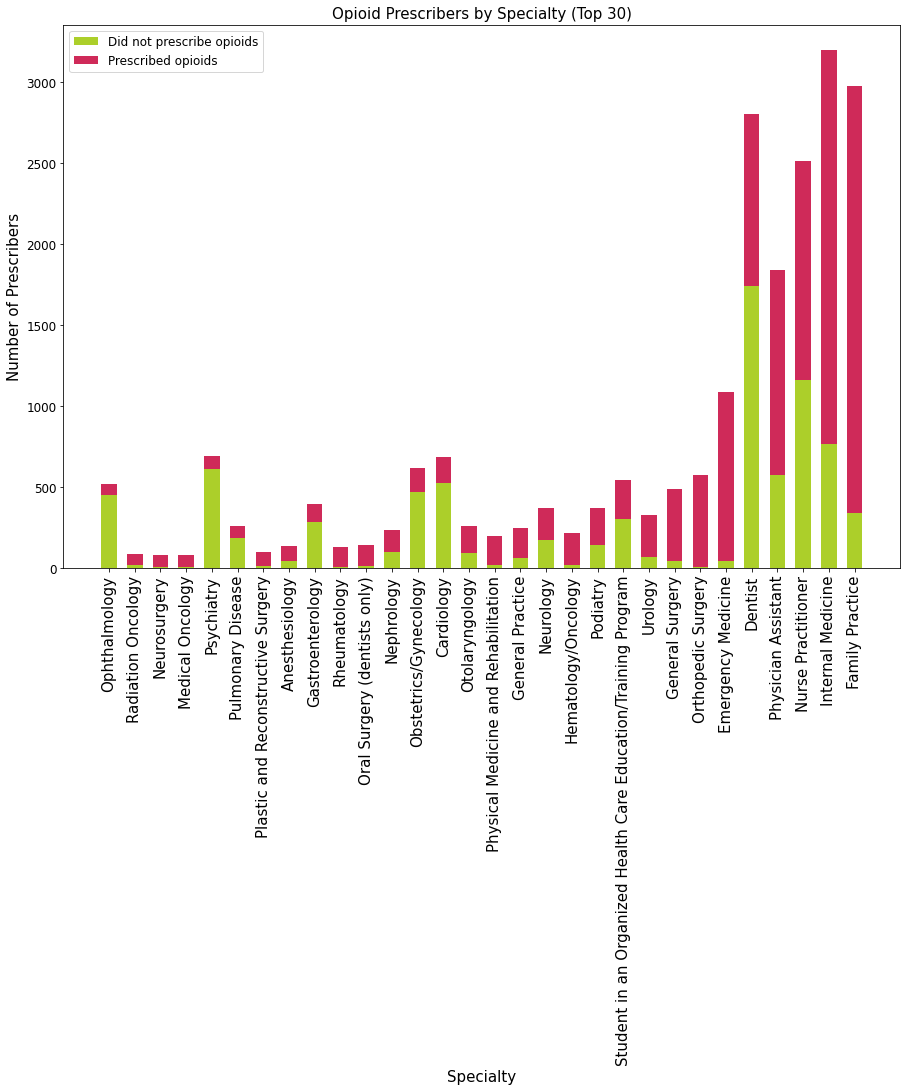

In [ ]:
# Opioid Prescriber count by Speciality and NPI for top 30 specialities
fig = plt.gcf()
fig.set_size_inches( 15, 10)

N = Specialty_count.shape[0]
ind = np.arange(N)
width = 0.6

p1 = plt.bar(ind, Specialty_count['Total_Prescribers']-Specialty_count['Opiod_Prescribers'], width, color='#ACCF2A');
p2 = plt.bar(ind, Specialty_count['Opiod_Prescribers'], width, bottom=Specialty_count['Total_Prescribers']-Specialty_count['Opiod_Prescribers'], color='#CF2A59');
plt.yticks(fontsize=12)
plt.ylabel("Number of Prescribers", fontsize=15)
plt.xticks(ind,Specialty_count['Specialty'], fontsize=15, rotation=90)
plt.xlabel('Specialty', fontsize=15)
plt.title("Opioid Prescribers by Specialty (Top 30)", fontsize=15)
plt.legend([p1[0], p2[0]], ["Did not prescribe opioids","Prescribed opioids"], fontsize=12, fancybox=True)
plt.show()

In [19]:
import plotly.graph_objects as go # or plotly.express as px
fig = go.Figure() # or any Plotly Express function e.g. px.bar(...)
# fig.add_trace( ... )
# fig.update_layout( ... )

import dash
import dash_core_components as dcc
import dash_html_components as html

app = dash.Dash()
app.layout = html.Div([
    dcc.Graph(figure=fig)
])

app.run_server(debug=True, use_reloader=False)  # Turn off reloader if inside Jupyter

Dash is running on http://127.0.0.1:8050/

 in production, use a production WSGI server like gunicorn instead.

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


In [23]:
tls.get_embed('https://plotly.com/~chris/1638')

'<iframe id="igraph" scrolling="no" style="border:none;" seamless="seamless" src="https://plotly.com/~chris/1638.embed" height="525" width="100%"></iframe>'

In [24]:
fig = px.scatter(Specialty_count, x='Opiod_Prescribers', y='Total_Prescribers'
                 ,size='Total_Prescribers', size_max=60
                 ,color= 'Specialty', hover_name="Specialty")
fig.update_layout(template='plotly_white')
fig.update_layout(title='Opiod_Prescribers Vs Total_Prescribers')
pio.write_html(fig, file='index.html', auto_open=True)
fig.show()

In [ ]:
# Top 10 state_distribution with opioid prescriber
state_distribute = df["State"][df["Opioid.Prescriber"] == 1].value_counts(normalize=True)[:10]

state_distribute

CA    0.099537
TX    0.064611
NY    0.059572
FL    0.059572
PA    0.046228
OH    0.038331
IL    0.037786
MI    0.037718
NC    0.033905
GA    0.027097
Name: State, dtype: float64

In [ ]:
# Top 10 state_groubed by opioid prescriber
state = df.groupby(['State'], as_index=False)['Opioid.Prescriber'].sum()
state.head(10) 

,State,Opioid.Prescriber
0,AA,0
1,AE,2
2,AK,27
3,AL,244
4,AR,159
5,AZ,331
6,CA,1462
7,CO,256
8,CT,202
9,DC,35


In [25]:
# Overview all Opioid prescribers per state is showing the highest states with drug abuse
import plotly.express as px
state = df.groupby(['State'], as_index=False)['Opioid.Prescriber'].sum() 

fig = px.bar(state, x='State', y='Opioid.Prescriber', color='Opioid.Prescriber');
pio.write_html(fig, file='index.html', auto_open=True)
fig.show()

In [ ]:
# We can look speciafically on the map at the TOP 12 states for prescription drug abuse
# States in the red areas that show the biggest impact with DRUG ABUSE
# States in the orange areas that show the medium impact with DRUG ABUSE
# States in the green areas that show the lower impact with DRUG ABUSE
map = folium.Map(location=[39.381266, -97.922211],
                        tiles = "Stamen Toner",
                        zoom_start = 4)

folium.Marker([36.778261, -119.417932],
              popup='California',
              icon=folium.Icon(color='red')
             ).add_to(map)

folium.Marker([31.968599, -99.901813], 
              popup='Texas',
              icon=folium.Icon(color='red') 
             ).add_to(map)

folium.Marker([27.664827, -81.515754], 
              popup='Florida',
              icon=folium.Icon(color='red') 
             ).add_to(map)
#icon=folium.Icon(color='red',icon='bicycle', prefix='fa')

folium.Marker([43.299428, -74.217933], 
              popup='New York',
              icon=folium.Icon(color='red') 
             ).add_to(map)
    
folium.Marker([41.203322, -77.194525], 
              popup='Pennsylvania',
              icon=folium.Icon(color='lightgreen',icon='bar-chart', prefix='fa') 
             ).add_to(map)

folium.Marker([40.417287, -82.907123], 
              popup='Ohio',
              icon=folium.Icon(color='lightgreen',icon='bar-chart', prefix='fa') 
             ).add_to(map)

folium.Marker([40.633125, -89.398528], 
              popup='Illinois',
              icon=folium.Icon(color='lightgreen',icon='bar-chart', prefix='fa') 
             ).add_to(map)

folium.Marker([44.314844, -85.602364], 
              popup='Michigan',
              icon=folium.Icon(color='lightgreen',icon='bar-chart', prefix='fa') 
             ).add_to(map)

folium.Marker([35.75957, -79.0193], 
              popup='North Carolina',
              icon=folium.Icon(color='orange',icon='bar-chart', prefix='fa') 
             ).add_to(map)

folium.Marker([32.157435, -82.907123], 
              popup='Georgia',
              icon=folium.Icon(color='orange',icon='bar-chart', prefix='fa') 
             ).add_to(map)

folium.Marker([42.407211, -71.382437], 
              popup='Massachusetts',
              icon=folium.Icon(color='orange',icon='bar-chart', prefix='fa') 
             ).add_to(map)

folium.Marker([47.751074, -120.740139], 
              popup='Washington',
              icon=folium.Icon(color='orange',icon='bar-chart', prefix='fa') 
             ).add_to(map)

map.add_child(folium.ClickForMarker(popup="EVEN THOUGH USA.WORLD IS AWESOME, IT SHOWS SOME SPOTS WITH OPIOIDS ABUSE"))

In [27]:
# Opioid Prescriber count by State and NPI for top 10 states
state_count = pd.DataFrame(df[['State','NPI']].groupby('State').count())

state_count.reset_index(level=0, inplace=True)

state_count.columns = ['State', 'Total_states_prescribers']

state_count_prescribedOpiods = pd.DataFrame(df.loc[df['Opioid.Prescriber']>0,['State','NPI']].groupby('State').count())
state_count_prescribedOpiods.reset_index(level=0, inplace=True)
state_count_prescribedOpiods.columns = ['State', 'Opiod_states_prescribers']
state_count = pd.merge(state_count, state_count_prescribedOpiods,  how='left', on="State")

state_count = state_count.fillna(0)

state_count = state_count.sort_values('Total_states_prescribers')
state_count.head(10)

,State,Total_states_prescribers,Opiod_states_prescribers
0,AA,1,0.0
13,GU,2,1.0
56,ZZ,2,1.0
1,AE,2,2.0
50,VI,3,3.0
55,WY,38,24.0
2,AK,39,27.0
51,VT,65,40.0
31,ND,66,39.0
29,MT,77,55.0


In [28]:
# Overview for the total_opioids for each state that has the highest amount of opioids
import plotly.express as px
state = df.groupby(['State'], as_index=False)['Opioid.Prescriber'].sum() 

fig = px.bar(state_count, x='State', y='Total_states_prescribers', color='Opiod_states_prescribers');
pio.write_html(fig, file='index.html', auto_open=True)
fig.show()

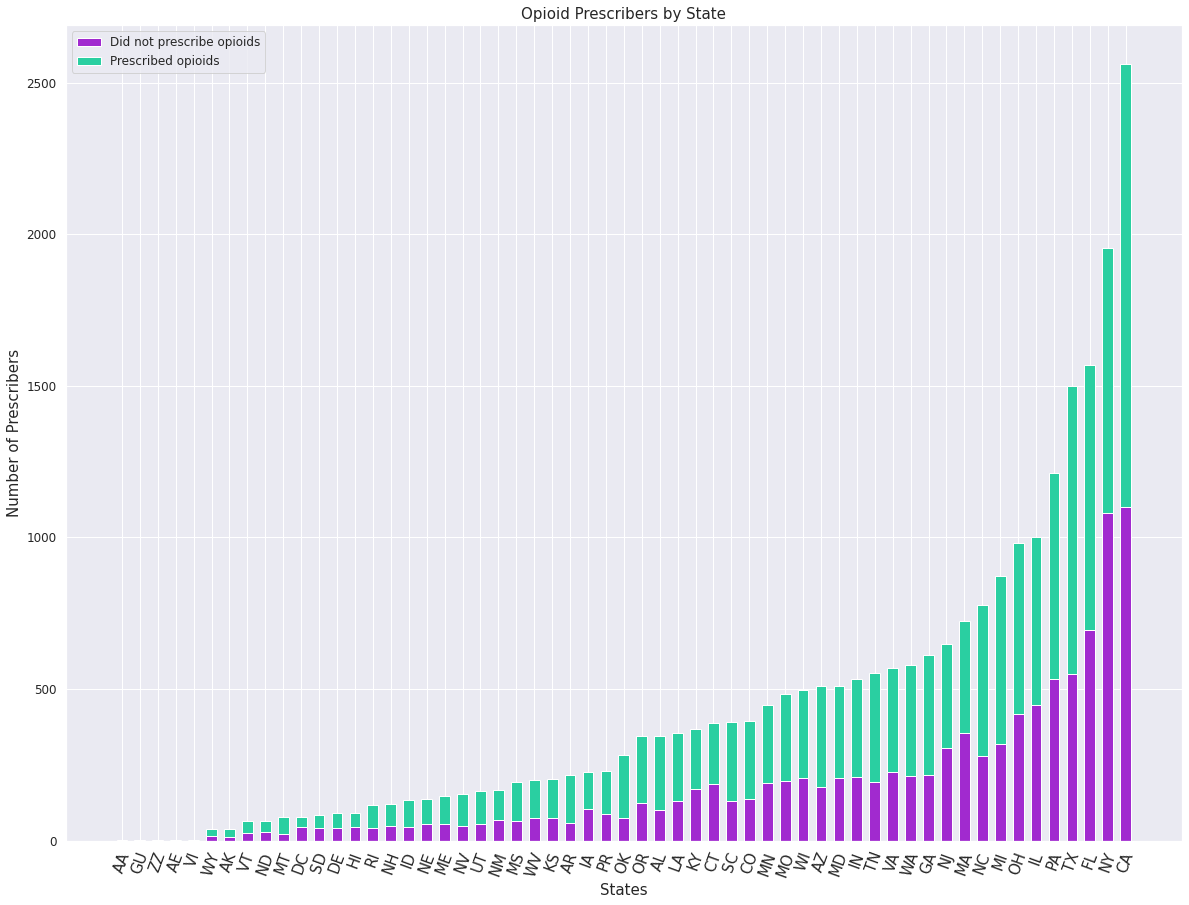

In [ ]:
# Opioid Prescriber count by State and NPI for top 30 states
fig = plt.gcf()
fig.set_size_inches(20, 15)

N = state_count.shape[0]
ind = np.arange(N)
width = 0.6

p1 = plt.bar(ind, state_count['Total_states_prescribers']-state_count['Opiod_states_prescribers'], width, color='#A12ACF')
p2 = plt.bar(ind, state_count['Opiod_states_prescribers'], width, bottom=state_count['Total_states_prescribers']-state_count['Opiod_states_prescribers'], color='#2ACFA1')
plt.yticks(fontsize=12)
plt.ylabel("Number of Prescribers", fontsize=15)
plt.xticks(ind,state_count['State'], fontsize=15, rotation=70)
plt.xlabel('States', fontsize=15)
plt.title("Opioid Prescribers by State", fontsize=15)
plt.legend([p1[0], p2[0]], ["Did not prescribe opioids","Prescribed opioids"], fontsize=12, fancybox=True)
plt.show()

In [ ]:
# Principal Component Analysis of dimensionality reduction to get 358 columns
specialty = pd.DataFrame(df.groupby(['Specialty']).count()['NPI']).sort_values('NPI')
specialty.loc[specialty['NPI']<40].shape

rare_specialty = list(specialty.loc[specialty['NPI']<40].index)

df.loc[df['Specialty'].isin(rare_specialty),'Specialty'] = df.loc[df['Specialty'].isin(rare_specialty),'Specialty'].apply(lambda x: 'Surgery' if 'Surgery' in list(x.split( )) else 'Other')

prescribers_data = df.drop( ['NPI','Credentials'], axis=1)

prescribers_data = pd.get_dummies(prescribers_data, columns=['Gender','Specialty','State'], drop_first=True)
prescribers_data

,ABILIFY,ACETAMINOPHEN.CODEINE,ACYCLOVIR,ADVAIR.DISKUS,AGGRENOX,ALENDRONATE.SODIUM,ALLOPURINOL,ALPRAZOLAM,AMIODARONE.HCL,AMITRIPTYLINE.HCL,AMLODIPINE.BESYLATE,AMLODIPINE.BESYLATE.BENAZEPRIL,AMOXICILLIN,AMOX.TR.POTASSIUM.CLAVULANATE,AMPHETAMINE.SALT.COMBO,ATENOLOL,ATORVASTATIN.CALCIUM,AVODART,AZITHROMYCIN,BACLOFEN,BD.ULTRA.FINE.PEN.NEEDLE,BENAZEPRIL.HCL,BENICAR,BENICAR.HCT,BENZTROPINE.MESYLATE,BISOPROLOL.HYDROCHLOROTHIAZIDE,BRIMONIDINE.TARTRATE,BUMETANIDE,BUPROPION.HCL.SR,BUPROPION.XL,BUSPIRONE.HCL,BYSTOLIC,CARBAMAZEPINE,CARBIDOPA.LEVODOPA,CARISOPRODOL,CARTIA.XT,CARVEDILOL,CEFUROXIME,CELEBREX,CEPHALEXIN,...,State_IL,State_IN,State_KS,State_KY,State_LA,State_MA,State_MD,State_ME,State_MI,State_MN,State_MO,State_MS,State_MT,State_NC,State_ND,State_NE,State_NH,State_NJ,State_NM,State_NV,State_NY,State_OH,State_OK,State_OR,State_PA,State_PR,State_RI,State_SC,State_SD,State_TN,State_TX,State_UT,State_VA,State_VI,State_VT,State_WA,State_WI,State_WV,State_WY,State_ZZ
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,134,0,0,15,0,0,0,0,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15,0,0,0,45,0,0,0,11,19,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19,42,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,43,0,0,0,21,0,0,0,0,58,0,0,0,0,0,13,0,0,27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,29,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,0,12,0,0,0,46,25,0,0,0,73,0,0,0,0,59,91,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
24996,0,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
24997,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
24998,0,0,0,0,0,0,0,16,0,0,32,12,0,0,0,20,91,0,0,0,0,0,0,0,0,0,0,0,0,21,0,0,0,0,0,0,12,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
#convert it to numpy arrays
X= prescribers_data.values

scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

pca = PCA(n_components=300)

pca.fit(X_scaled)

#The amount of variance that each PC explains
var= pca.explained_variance_ratio_

#Cumulative Variance explains
cum_var = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
cum_var

array([16.7 , 20.7 , 23.19, 25.13, 26.97, 28.42, 29.78, 31.01, 32.17,
       33.25, 34.23, 35.18, 36.02, 36.8 , 37.54, 38.2 , 38.84, 39.45,
       40.02, 40.57, 41.07, 41.56, 42.03, 42.48, 42.91, 43.33, 43.74,
       44.14, 44.52, 44.9 , 45.26, 45.62, 45.98, 46.33, 46.67, 47.01,
       47.34, 47.67, 48.  , 48.32, 48.64, 48.96, 49.28, 49.6 , 49.92,
       50.24, 50.55, 50.86, 51.17, 51.48, 51.79, 52.1 , 52.41, 52.72,
       53.03, 53.33, 53.63, 53.93, 54.23, 54.53, 54.83, 55.13, 55.43,
       55.73, 56.03, 56.32, 56.61, 56.9 , 57.19, 57.48, 57.77, 58.06,
       58.35, 58.64, 58.93, 59.22, 59.51, 59.8 , 60.09, 60.38, 60.67,
       60.96, 61.25, 61.54, 61.83, 62.12, 62.41, 62.69, 62.97, 63.25,
       63.53, 63.81, 64.09, 64.37, 64.65, 64.93, 65.21, 65.49, 65.77,
       66.05, 66.33, 66.61, 66.89, 67.17, 67.45, 67.72, 67.99, 68.26,
       68.53, 68.8 , 69.07, 69.34, 69.61, 69.88, 70.15, 70.42, 70.68,
       70.94, 71.2 , 71.46, 71.72, 71.98, 72.24, 72.49, 72.74, 72.99,
       73.24, 73.49,

Text(0.5, 1.0, 'Scree Plot')

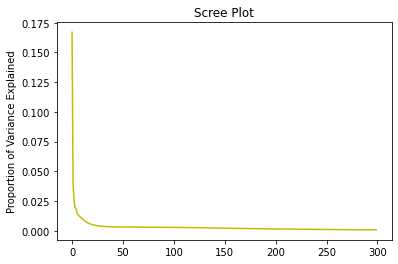

In [ ]:
# Screen plot for the principal components
plt.plot(var, color='y');
plt.ylabel('Principal Components')
plt.ylabel('Proportion of Variance Explained')
plt.title('Scree Plot')

In [ ]:
#Looking at above plot I'm taking 20 variables
pca = PCA(n_components=20)

# pca.fit(X_scaled)
X1=pca.fit_transform(X_scaled)

In [ ]:
print ("Explained variance by component: %s" % pca.explained_variance_ratio_)

Explained variance by component: [0.16701014 0.0399965  0.02491605 0.01941242 0.01838096 0.01448751
 0.01355348 0.01233541 0.011597   0.0107568  0.00981811 0.00951473
 0.00843702 0.00780007 0.00741794 0.00662292 0.00638697 0.00608134
 0.00573459 0.0054801 ]


In [ ]:
print ("Variance explained by first 10 factors: %s" % (pca.explained_variance_ratio_[0:9].sum()/pca.explained_variance_ratio_.sum()))
print ("Since these explain ~80% of the variance they are selected for further analysis")

Variance explained by first 10 factors: 0.7928462239564946
Since these explain ~80% of the variance they are selected for further analysis


In [ ]:
# Turnig those pca component into a new DataFrame
newFactors = pd.DataFrame(pca.components_,columns=prescribers_data.columns)
newFactors

,ABILIFY,ACETAMINOPHEN.CODEINE,ACYCLOVIR,ADVAIR.DISKUS,AGGRENOX,ALENDRONATE.SODIUM,ALLOPURINOL,ALPRAZOLAM,AMIODARONE.HCL,AMITRIPTYLINE.HCL,AMLODIPINE.BESYLATE,AMLODIPINE.BESYLATE.BENAZEPRIL,AMOXICILLIN,AMOX.TR.POTASSIUM.CLAVULANATE,AMPHETAMINE.SALT.COMBO,ATENOLOL,ATORVASTATIN.CALCIUM,AVODART,AZITHROMYCIN,BACLOFEN,BD.ULTRA.FINE.PEN.NEEDLE,BENAZEPRIL.HCL,BENICAR,BENICAR.HCT,BENZTROPINE.MESYLATE,BISOPROLOL.HYDROCHLOROTHIAZIDE,BRIMONIDINE.TARTRATE,BUMETANIDE,BUPROPION.HCL.SR,BUPROPION.XL,BUSPIRONE.HCL,BYSTOLIC,CARBAMAZEPINE,CARBIDOPA.LEVODOPA,CARISOPRODOL,CARTIA.XT,CARVEDILOL,CEFUROXIME,CELEBREX,CEPHALEXIN,...,State_IL,State_IN,State_KS,State_KY,State_LA,State_MA,State_MD,State_ME,State_MI,State_MN,State_MO,State_MS,State_MT,State_NC,State_ND,State_NE,State_NH,State_NJ,State_NM,State_NV,State_NY,State_OH,State_OK,State_OR,State_PA,State_PR,State_RI,State_SC,State_SD,State_TN,State_TX,State_UT,State_VA,State_VI,State_VT,State_WA,State_WI,State_WV,State_WY,State_ZZ
0,0.037959,0.043303,0.026703,0.071982,0.064683,0.070977,0.099745,0.071217,0.053290,0.079425,0.114595,0.073835,0.032282,0.059845,0.014295,0.094715,0.101801,0.030954,0.080256,0.063282,0.056132,0.068231,0.067102,0.054262,0.022202,0.047825,0.003731,0.054880,0.048066,0.038417,0.060362,0.058163,0.044480,0.035180,0.027919,0.047571,0.086857,0.036777,0.077191,0.050431,...,-0.001326,0.002783,-0.000071,0.003173,0.003080,-0.002451,-0.003202,-0.000529,-0.001218,-0.000958,0.000570,0.003420,-0.000467,0.002866,0.000154,-0.000988,-0.001691,-0.001144,-0.002096,-0.000061,-0.002269,0.002219,0.000064,-0.001810,0.001507,0.005082,0.000370,0.002537,-0.000050,0.002497,-0.001114,-0.002102,-0.000893,0.000262,-0.001119,-0.003165,-0.001165,0.001853,0.000419,-0.000430
1,0.197392,-0.016986,-0.007442,-0.021766,0.016311,-0.034114,-0.035279,0.078564,-0.046596,0.042681,-0.056378,-0.055133,-0.013244,-0.011314,0.101450,-0.058857,-0.065631,-0.014424,-0.032219,0.041373,-0.038421,-0.034971,-0.048022,-0.044826,0.189789,-0.024567,0.007280,-0.012687,0.138277,0.130463,0.144042,-0.042356,0.110501,0.045705,0.015476,-0.049901,-0.061342,-0.004645,-0.020839,-0.000358,...,-0.001876,-0.000246,0.001648,-0.002627,-0.001337,0.010681,-0.001971,0.002367,0.001403,0.004292,-0.000610,-0.002895,0.000383,-0.001287,-0.000454,0.001230,0.002381,-0.005131,0.003565,0.000239,-0.006696,0.004087,-0.001113,0.001978,-0.001672,-0.007134,-0.001980,-0.003628,0.003623,-0.000263,-0.001298,0.001947,0.000820,-0.001500,0.002140,0.002332,0.001821,-0.000456,-0.000390,-0.000153
2,-0.079867,0.050114,0.027443,0.034693,-0.002134,0.030936,0.009821,0.041474,-0.132741,0.080090,-0.037237,-0.014836,0.025446,0.033213,-0.012205,-0.030822,-0.065082,0.010235,0.042026,0.120131,0.024598,-0.009676,-0.040004,-0.023856,-0.086033,-0.003457,-0.008747,-0.035233,-0.037676,-0.042265,-0.045795,-0.063664,-0.010855,0.012550,0.157955,-0.076950,-0.105517,0.004147,0.054417,0.036266,...,-0.003779,0.001332,0.001901,0.000571,0.003929,-0.005440,0.002742,0.001953,0.003243,-0.003045,0.002070,0.001575,0.001637,0.004114,-0.001970,-0.000468,-0.002200,-0.006781,0.000909,0.003526,-0.010596,-0.004019,0.006805,0.002159,-0.007447,-0.007163,-0.002434,-0.004336,-0.002630,0.007401,0.001484,0.002940,0.000122,0.000433,0.001139,0.002115,-0.002106,0.000121,0.002371,-0.000179
3,-0.014776,-0.020777,-0.025732,-0.075077,0.016303,-0.077009,-0.029233,-0.006260,0.172337,0.000148,-0.000821,-0.034908,-0.030228,-0.049214,-0.007590,-0.002183,0.028136,-0.040286,-0.073434,0.083186,-0.117337,-0.023757,0.021689,0.001543,-0.021872,-0.012331,0.005351,0.059844,-0.026906,-0.031158,-0.020197,0.066215,0.010042,0.041629,0.113994,0.080033,0.118327,-0.013666,-0.010846,-0.021844,...,-0.001995,0.008041,0.005246,0.005537,0.008397,-0.000918,-0.000036,-0.002443,0.000372,-0.002479,0.002482,0.002827,0.000176,0.004930,0.001439,0.000225,0.001034,0.001726,-0.003447,0.001490,-0.009488,0.003533,0.005403,0.002143,0.005997,-0.006788,-0.002592,0.001907,0.002086,0.000230,-0.004118,-0.001429,-0.001292,-0.002411,0.001204,0.004186,0.004253,-0

In [ ]:
# Selecting the top 10 factors in terms of explained variance
newFactors = newFactors.loc[0:9]

In [ ]:
newFactors

,ABILIFY,ACETAMINOPHEN.CODEINE,ACYCLOVIR,ADVAIR.DISKUS,AGGRENOX,ALENDRONATE.SODIUM,ALLOPURINOL,ALPRAZOLAM,AMIODARONE.HCL,AMITRIPTYLINE.HCL,AMLODIPINE.BESYLATE,AMLODIPINE.BESYLATE.BENAZEPRIL,AMOXICILLIN,AMOX.TR.POTASSIUM.CLAVULANATE,AMPHETAMINE.SALT.COMBO,ATENOLOL,ATORVASTATIN.CALCIUM,AVODART,AZITHROMYCIN,BACLOFEN,BD.ULTRA.FINE.PEN.NEEDLE,BENAZEPRIL.HCL,BENICAR,BENICAR.HCT,BENZTROPINE.MESYLATE,BISOPROLOL.HYDROCHLOROTHIAZIDE,BRIMONIDINE.TARTRATE,BUMETANIDE,BUPROPION.HCL.SR,BUPROPION.XL,BUSPIRONE.HCL,BYSTOLIC,CARBAMAZEPINE,CARBIDOPA.LEVODOPA,CARISOPRODOL,CARTIA.XT,CARVEDILOL,CEFUROXIME,CELEBREX,CEPHALEXIN,...,State_IL,State_IN,State_KS,State_KY,State_LA,State_MA,State_MD,State_ME,State_MI,State_MN,State_MO,State_MS,State_MT,State_NC,State_ND,State_NE,State_NH,State_NJ,State_NM,State_NV,State_NY,State_OH,State_OK,State_OR,State_PA,State_PR,State_RI,State_SC,State_SD,State_TN,State_TX,State_UT,State_VA,State_VI,State_VT,State_WA,State_WI,State_WV,State_WY,State_ZZ
0,0.037959,0.043303,0.026703,0.071982,0.064683,0.070977,0.099745,0.071217,0.053290,0.079425,0.114595,0.073835,0.032282,0.059845,0.014295,0.094715,0.101801,0.030954,0.080256,0.063282,0.056132,0.068231,0.067102,0.054262,0.022202,0.047825,0.003731,0.054880,0.048066,0.038417,0.060362,0.058163,0.044480,0.035180,0.027919,0.047571,0.086857,0.036777,0.077191,0.050431,...,-0.001326,0.002783,-0.000071,0.003173,0.003080,-0.002451,-0.003202,-0.000529,-0.001218,-0.000958,0.000570,0.003420,-0.000467,0.002866,0.000154,-0.000988,-0.001691,-0.001144,-0.002096,-0.000061,-0.002269,0.002219,0.000064,-0.001810,0.001507,0.005082,0.000370,0.002537,-0.000050,0.002497,-0.001114,-0.002102,-0.000893,0.000262,-0.001119,-0.003165,-0.001165,0.001853,0.000419,-0.000430
1,0.197392,-0.016986,-0.007442,-0.021766,0.016311,-0.034114,-0.035279,0.078564,-0.046596,0.042681,-0.056378,-0.055133,-0.013244,-0.011314,0.101450,-0.058857,-0.065631,-0.014424,-0.032219,0.041373,-0.038421,-0.034971,-0.048022,-0.044826,0.189789,-0.024567,0.007280,-0.012687,0.138277,0.130463,0.144042,-0.042356,0.110501,0.045705,0.015476,-0.049901,-0.061342,-0.004645,-0.020839,-0.000358,...,-0.001876,-0.000246,0.001648,-0.002627,-0.001337,0.010681,-0.001971,0.002367,0.001403,0.004292,-0.000610,-0.002895,0.000383,-0.001287,-0.000454,0.001230,0.002381,-0.005131,0.003565,0.000239,-0.006696,0.004087,-0.001113,0.001978,-0.001672,-0.007134,-0.001980,-0.003628,0.003623,-0.000263,-0.001298,0.001947,0.000820,-0.001500,0.002140,0.002332,0.001821,-0.000456,-0.000390,-0.000153
2,-0.079867,0.050114,0.027443,0.034693,-0.002134,0.030936,0.009821,0.041474,-0.132741,0.080090,-0.037237,-0.014836,0.025446,0.033213,-0.012205,-0.030822,-0.065082,0.010235,0.042026,0.120131,0.024598,-0.009676,-0.040004,-0.023856,-0.086033,-0.003457,-0.008747,-0.035233,-0.037676,-0.042265,-0.045795,-0.063664,-0.010855,0.012550,0.157955,-0.076950,-0.105517,0.004147,0.054417,0.036266,...,-0.003779,0.001332,0.001901,0.000571,0.003929,-0.005440,0.002742,0.001953,0.003243,-0.003045,0.002070,0.001575,0.001637,0.004114,-0.001970,-0.000468,-0.002200,-0.006781,0.000909,0.003526,-0.010596,-0.004019,0.006805,0.002159,-0.007447,-0.007163,-0.002434,-0.004336,-0.002630,0.007401,0.001484,0.002940,0.000122,0.000433,0.001139,0.002115,-0.002106,0.000121,0.002371,-0.000179
3,-0.014776,-0.020777,-0.025732,-0.075077,0.016303,-0.077009,-0.029233,-0.006260,0.172337,0.000148,-0.000821,-0.034908,-0.030228,-0.049214,-0.007590,-0.002183,0.028136,-0.040286,-0.073434,0.083186,-0.117337,-0.023757,0.021689,0.001543,-0.021872,-0.012331,0.005351,0.059844,-0.026906,-0.031158,-0.020197,0.066215,0.010042,0.041629,0.113994,0.080033,0.118327,-0.013666,-0.010846,-0.021844,...,-0.001995,0.008041,0.005246,0.005537,0.008397,-0.000918,-0.000036,-0.002443,0.000372,-0.002479,0.002482,0.002827,0.000176,0.004930,0.001439,0.000225,0.001034,0.001726,-0.003447,0.001490,-0.009488,0.003533,0.005403,0.002143,0.005997,-0.006788,-0.002592,0.001907,0.002086,0.000230,-0.004118,-0.001429,-0.001292,-0.002411,0.001204,0.004186,0.004253,-0

In [ ]:
# Important factors which constitute higher weightage in the newly discovered factors or components turning to a list
impFactors = list(set(pd.DataFrame(newFactors.max())[pd.DataFrame(newFactors.max()> 0.2)[0]].index).union(set(pd.DataFrame(newFactors.min())[pd.DataFrame(newFactors.min()< -0.2)[0]].index)))
impFactors

['TRAVATAN.Z',
 'NOVOLOG.FLEXPEN',
 'Specialty_Ophthalmology',
 'TIMOLOL.MALEATE',
 'HUMALOG',
 'LUMIGAN',
 'LATANOPROST',
 'LANTUS.SOLOSTAR',
 'BD.ULTRA.FINE.PEN.NEEDLE',
 'Specialty_Neurology',
 'LEVEMIR.FLEXPEN',
 'NOVOLOG',
 'AVODART',
 'BRIMONIDINE.TARTRATE',
 'PRIMIDONE',
 'VOLTAREN',
 'MORPHINE.SULFATE.ER',
 'DORZOLAMIDE.TIMOLOL',
 'Specialty_Endocrinology',
 'FINASTERIDE',
 'RESTASIS',
 'LOVAZA']

In [ ]:
# Then Turn it into a dataframe
pd.DataFrame(impFactors)


,0
0,TRAVATAN.Z
1,NOVOLOG.FLEXPEN
2,Specialty_Ophthalmology
3,TIMOLOL.MALEATE
4,HUMALOG
5,LUMIGAN
6,LATANOPROST
7,LANTUS.SOLOSTAR
8,BD.ULTRA.FINE.PEN.NEEDLE
9,Specialty_Neurology


In [ ]:
newFactors_ = newFactors[impFactors]

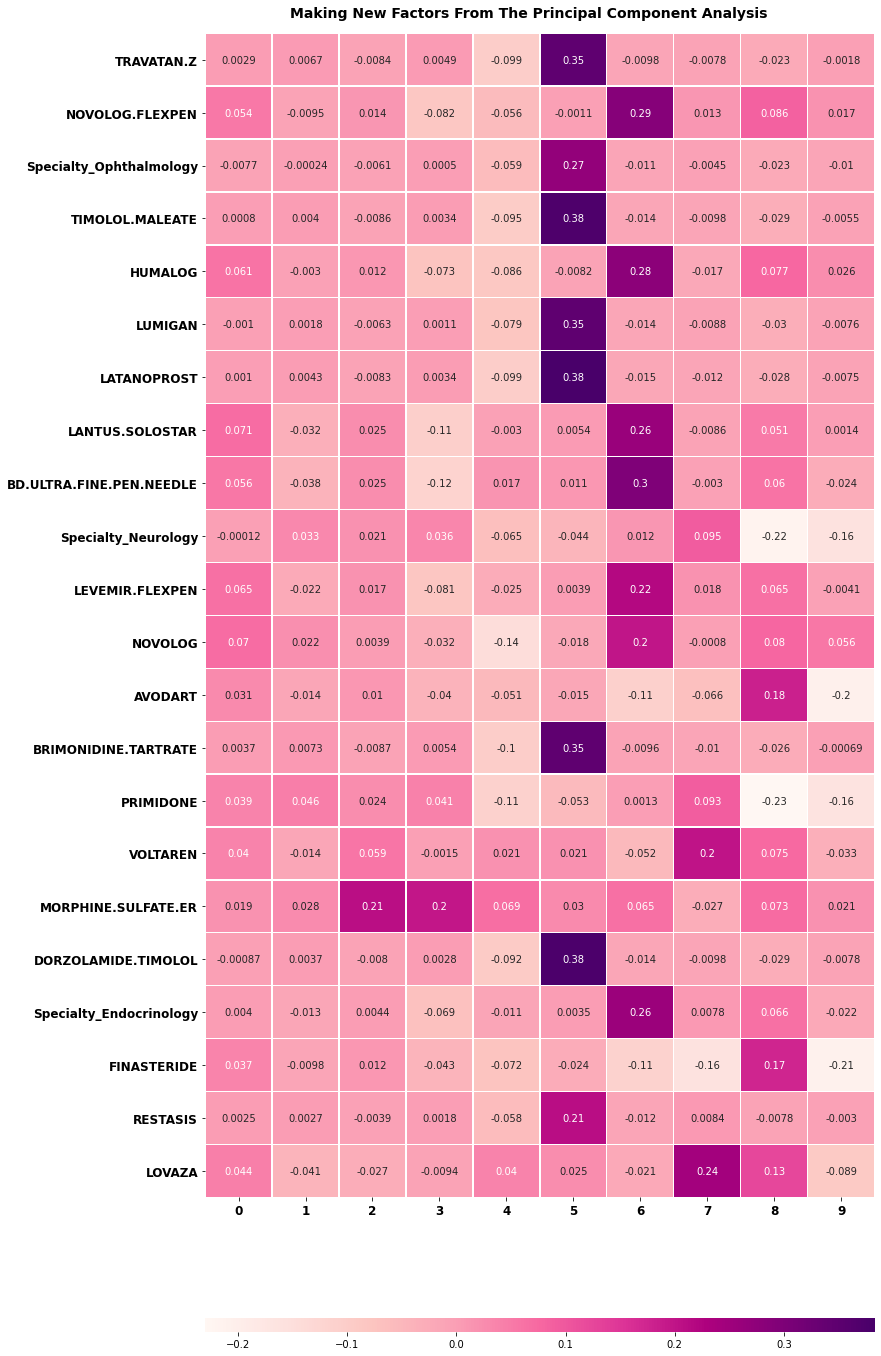

In [ ]:
# Making new factors from the PCA with numeric values in each cell by Heatmap
fig3, ax = plt.subplots(figsize=(12, 25))
fig3.subplots_adjust(top=.965)
plt.suptitle("Making New Factors From The Principal Component Analysis", fontsize=14, fontweight='bold')

ax.set_yticklabels(ax.get_yticklabels(), ha="right", fontsize=12, weight='bold')
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12, weight='bold')

cbar_kws = {'orientation':"horizontal", 'pad':0.08, 'aspect':50}
sns.heatmap(newFactors_.T, annot=True, linewidths=.3, ax=ax, cmap='RdPu', cbar_kws=cbar_kws);
plt.savefig('Making New Factors From The Principal Component Analysis.png')